<h1>Validando la solución a la pregunta: ¿Podemos predecir las cancelaciones?</h1>

In [1]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import modulo_conn_sql as mcq

Dia Especifico de programacion

<b>ProgramacionInteres</b> = Programacion - Pedidos( FechaHoraCancelacion < (FechaHoraClasificiacion - 25min))  & FechaHoraCreacion < FechaHoraClasificacion )

In [2]:
#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

In [3]:
def set_asertividad(row):
    if row.PedidoCancelado == 1 and row.Clasificacion == 1:
        return "vp"
    elif row.PedidoCancelado == 1 and row.Clasificacion == 0:
        return "fn"
    elif row.PedidoCancelado == 0 and row.Clasificacion == 0:
        return "vn"
    elif row.PedidoCancelado == 0 and row.Clasificacion == 1:
        return "fp"
        

In [4]:
#Variables 
pais='Colombia'
dias = 3

#listado de versiones a comparar
#versiones = ['S1','S2', 'S3', 'S4','J1','J2', 'J3', 'J4',  'n500', 'n500_2', 'n500_3']
versiones = ['S4', 'J4',  'n500', 'n500_2', 'n500_3', 'n500_4']

In [5]:
#Dataset de la programación
df_pedidos = querySQL( "{CALL SCAC_AP11_Dataset_Pedidos (?,?)}" , (pais, dias) )
df_pedidos = df_pedidos.fillna(value=np.nan)
df_pedidos['Pedido'] = df_pedidos['Pedido'].str[:10]
df_pedidos['year_month'] = df_pedidos.FechaEntrega.dt.to_period('M')

#Dataset resultado de clasificaciones por version
df_clasificacion = querySQL( "SELECT * FROM SCAC_AT34_ResultadosClasificacionCancelaciones" , () )
df_clasificacion['Pedido'] = df_clasificacion['Pedido'].str[:10]

In [6]:
df = pd.DataFrame()
for x in versiones:
    #obtener 
    df_clasificacion_temp = df_clasificacion[df_clasificacion['Version']==x]
    # Unir dataset de pedidos y clasificaciones
    df_programacion = pd.DataFrame()
    df_programacion = pd.merge(df_pedidos, df_clasificacion_temp, how='inner', on='Pedido').drop(columns='ID', axis=0)
    #identificacion de clasificaciones correctas e incorrectas
    if len(df_programacion) > 0 :
        df_programacion['Asertividad'] = df_programacion.apply(set_asertividad, axis=1)
        #se hace conteo de los resultados 
        df_group = df_programacion.groupby(['FechaEntrega','Version', 'Asertividad'])['Obra'].agg('count').reset_index()
        df_group['FechaEntrega'] = df_group['FechaEntrega'].dt.day
        df_group.rename(columns = {'Obra':'Cant Pedidos'}, inplace = True)
        if len(df) > 0:
            df = pd.concat([df, df_group])
        else: 
            df = df_group

Text(0.5, 1.0, 'Falsos Negativos')

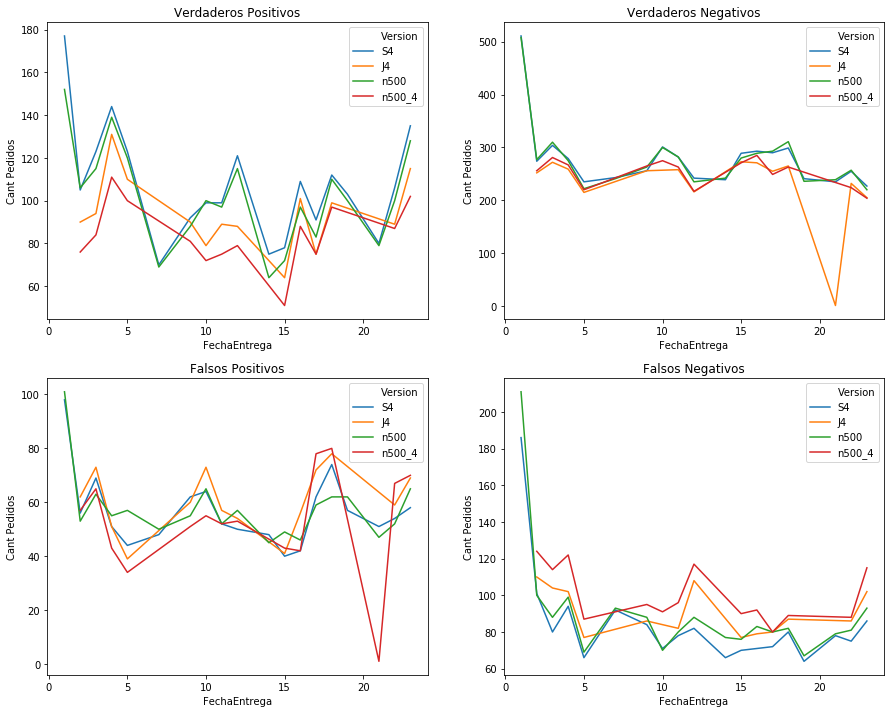

In [7]:
fig, ax=plt.subplots(2,2, figsize=(15,12))
sns.lineplot(data=df[df['Asertividad']=='vp'], x="FechaEntrega", y="Cant Pedidos", hue='Version', ax=ax[0,0])
ax[0,0].set_title('Verdaderos Positivos')

sns.lineplot(data=df[df['Asertividad']=='vn'], x="FechaEntrega", y="Cant Pedidos", hue='Version', ax=ax[0,1])
ax[0,1].set_title('Verdaderos Negativos')

sns.lineplot(data=df[df['Asertividad']=='fp'], x="FechaEntrega", y="Cant Pedidos", hue='Version', ax=ax[1,0])
ax[1,0].set_title('Falsos Positivos')

sns.lineplot(data=df[df['Asertividad']=='fn'], x="FechaEntrega", y="Cant Pedidos", hue='Version', ax=ax[1,1])
ax[1,1].set_title('Falsos Negativos')


<h3>Calidad predicción - Verdaderas Cancelaciones</h3>

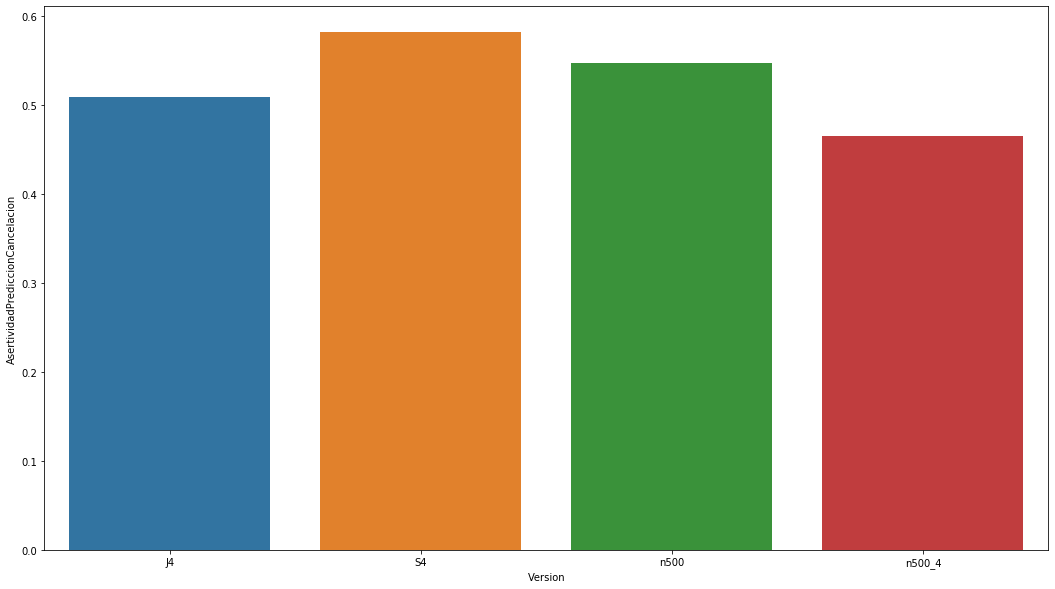

In [8]:
df_qa = pd.merge( df[df['Asertividad']=='vp'].groupby(['FechaEntrega','Version'])['Cant Pedidos'].agg('sum').reset_index(), df[(df['Asertividad']=='vp')|(df['Asertividad']=='fn')].groupby(['FechaEntrega','Version'])['Cant Pedidos'].agg('sum').reset_index() , on=['FechaEntrega','Version'] )
df_qa['AsertividadPrediccionCancelacion'] = df_qa['Cant Pedidos_x'] / df_qa['Cant Pedidos_y']
df_qa = df_qa.groupby(['Version'])['AsertividadPrediccionCancelacion'].agg('median').reset_index()
fig, ax=plt.subplots(0,0, figsize=(18,10))
sns.barplot(x='Version', y='AsertividadPrediccionCancelacion', data=df_qa)

<h3>Calidad predicción - Verdaderas Confirmaciones</h3>

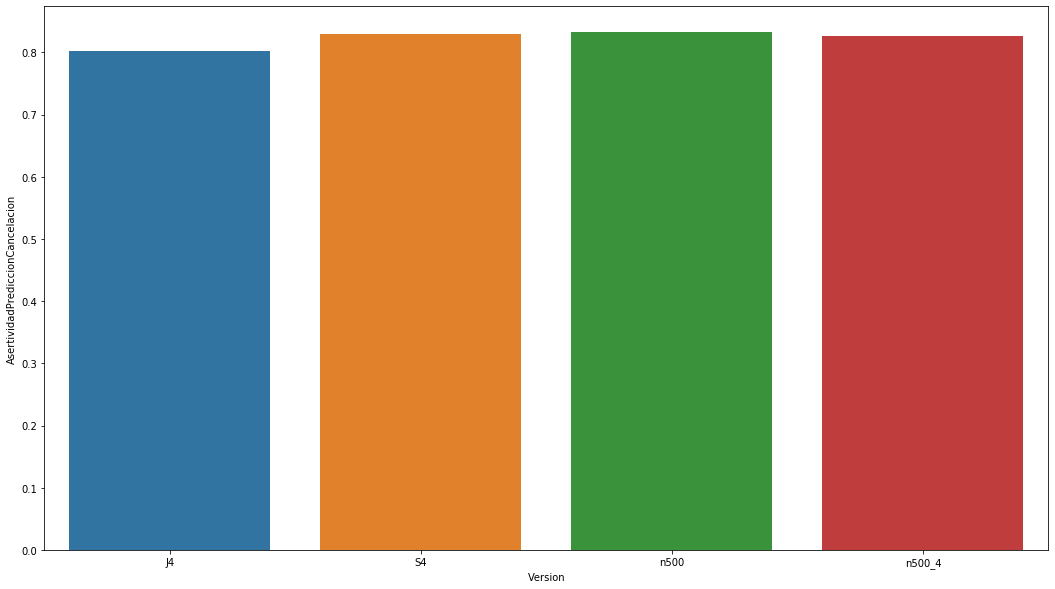

In [9]:
df_qa = pd.merge( df[df['Asertividad']=='vn'].groupby(['FechaEntrega','Version'])['Cant Pedidos'].agg('sum').reset_index(), df[(df['Asertividad']=='vn')|(df['Asertividad']=='fp')].groupby(['FechaEntrega','Version'])['Cant Pedidos'].agg('sum').reset_index() , on=['FechaEntrega','Version'] )
df_qa['AsertividadPrediccionCancelacion'] = df_qa['Cant Pedidos_x'] / df_qa['Cant Pedidos_y']
df_qa = df_qa.groupby(['Version'])['AsertividadPrediccionCancelacion'].agg('median').reset_index()
fig, ax=plt.subplots(0,0, figsize=(18,10))
sns.barplot(x='Version', y='AsertividadPrediccionCancelacion', data=df_qa)

vp + fn = Totales Cancelaciones

In [10]:
(149)/(149+91)

0.6208333333333333